In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, datasets, callbacks

# Data Preparation

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [ ]:
def preprocess_images(images):
  images = images.astype("float32")/255.0
  images = np.pad(images, ((0,0), (2,2), (2,2)), constant_values=0.0)
  images = np.expand_dims(images, -1)
  return images

In [ ]:
x_train =  preprocess_images(x_train)
x_test = preprocess_images(x_test)

# Helper Functions to Display Images

In [ ]:
def sample_batch(dataset):
  batch= dataset.take(1).get_single_element()
  if isinstance(batch, tuple):
    batch = batch[0]
  return batch.numpy()

def display_images(images, number_images_to_display=10, size=(20,3), cmap="gray_r", as_type="float32"):
  if images.max()>1.0:
    images=images/255.0
  elif images.min() <0.0:
    images = (images+1.0)/2.0

  plt.figure(figsize=size)

  for i in range(number_images_to_display):
    x1 = plt.subplot(1, number_images_to_display, i+1)
    plt.imshow(images[i].astype(as_type), cmap=cmap)
    plt.axis("off")

  plt.show()

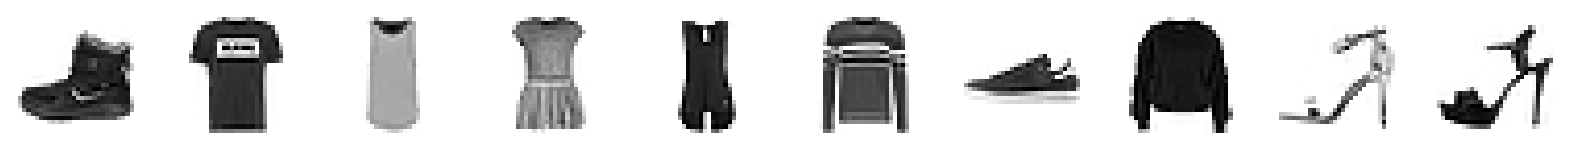

In [ ]:
display_images(x_train)

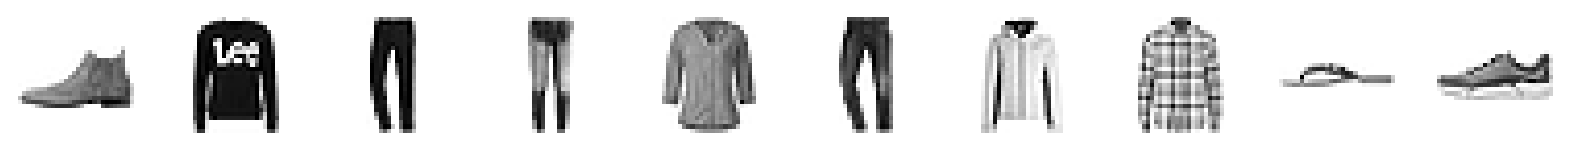

In [ ]:
display_images(x_test)

#Design Autoencoder

In [ ]:
IMAGE_SIZE=32
CHANNELS=1
EPOCHS=5
EMBEDDING_DIM=2
BATCH_SIZE=100
BUFFER_SIZE=1000
VALIDATION_SPLIT=0.2

In [ ]:
#ENCODER

#Input layer of encoder
encoder_input = layers.Input(
    shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input_layer"
)

#Stack of conv2D layers
x = layers.Conv2D(32, (3,3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), strides=2, activation="relu", padding="same")(x)

#Flatten the output from last conv layer to a vector
shape_before_flatten = K.int_shape(x)[1:] #Required in future by deocoder
x = layers.Flatten()(x)

#Dense layer which will connect this flattened vector to 2D embeddings / context vector
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output_layer")(x)

encoder = models.Model(encoder_input, encoder_output)

#Print Model's summary
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_layer (Input  [(None, 32, 32, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output_layer (Dens  (None, 2)                 4098      
 e)                                                          

In [ ]:
#DECODER

#Input layer
decoder_input = layers.Input(shape=(2,), name="decoder_input_layer")

#connect input to Dense Layer
x = layers.Dense(np.prod(shape_before_flatten))(decoder_input)

#reshaping to feed as input to first Conv2DTranspose layer
x = layers.Reshape(shape_before_flatten)(x)

#stack of conv2DTranspose layers
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(1, (3,3), strides=1, activation="sigmoid", padding="same", name="decoder_output_layer")(x)

decoder = models.Model(decoder_input, decoder_output)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (Input  [(None, 2)]               0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                           

#Join Encoder to Decoder

In [ ]:
#Autoencoder

autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_layer (Input  [(None, 32, 32, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output_layer (Dens  (None, 2)                 4098      
 e)                                                        

#Training our Autoencoder

In [ ]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint(
    filepath = "./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor="loss",
    mode="min",
    save_best_only = True,
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./tensorboard_logs")

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data = (x_test, x_test),
    callbacks = [model_checkpoint, tensorboard_callback]
)

Epoch 1/5
600/600 [==============================] - 21s 16ms/step - loss: 0.3024 - val_loss: 0.2675
Epoch 2/5
600/600 [==============================] - 9s 16ms/step - loss: 0.2612 - val_loss: 0.2585
Epoch 3/5
600/600 [==============================] - 9s 15ms/step - loss: 0.2558 - val_loss: 0.2557
Epoch 4/5
600/600 [==============================] - 8s 13ms/step - loss: 0.2532 - val_loss: 0.2540
Epoch 5/5
600/600 [==============================] - 7s 12ms/step - loss: 0.2517 - val_loss: 0.2525


In [ ]:
#save the checkpoints / trained model

autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

# Reconstruct Images using our trained Autoencoder

In [ ]:
number_images = 5000
example_images = x_test[:number_images]
example_labels = y_test[:number_images]

In [ ]:
predicted_images = autoencoder.predict(example_images)

157/157 [==============================] - 0s 3ms/step


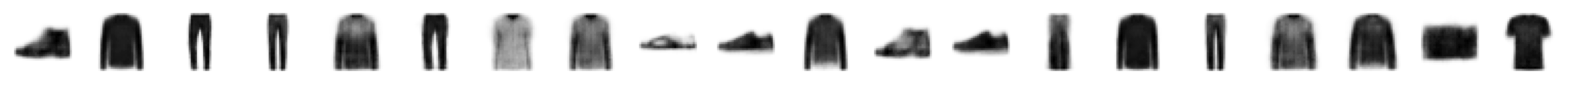

In [ ]:
display_images(predicted_images, number_images_to_display=20)

# Visuzalize Embeddings /  Latent Space

In [ ]:
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [ ]:
print(embeddings[:1])

[[-1.4210792 -5.157069 ]]


In [ ]:
print(embeddings[:10])

[[-1.4210792  -5.157069  ]
 [ 0.54150903  0.15281601]
 [10.267807    3.4886434 ]
 [ 9.9598465   0.5105784 ]
 [ 1.0647945  -1.222867  ]
 [ 5.9346395   2.7252252 ]
 [ 2.6855354  -2.7764804 ]
 [ 1.6602167  -1.7743502 ]
 [ 1.524987   -9.3562355 ]
 [ 0.15690668 -7.003792  ]]


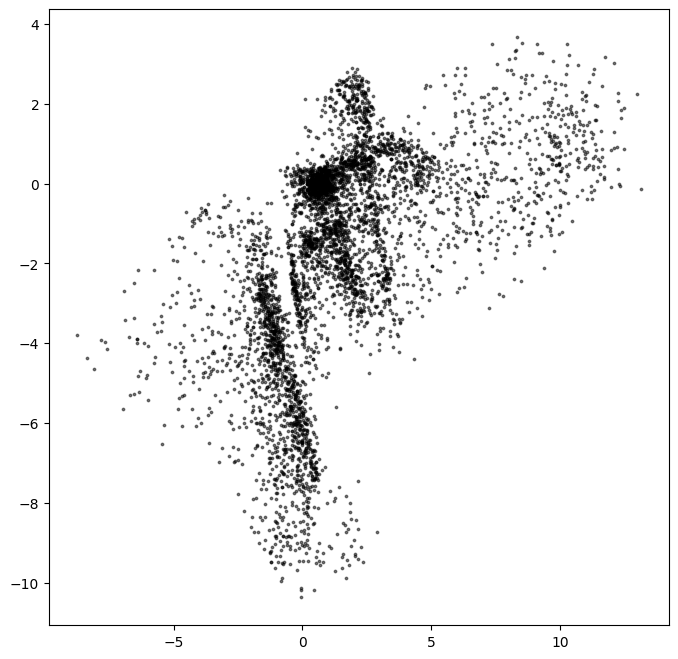

In [ ]:
fig_size = 8

plt.figure(figsize=(fig_size,fig_size))
plt.scatter(embeddings[:,0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

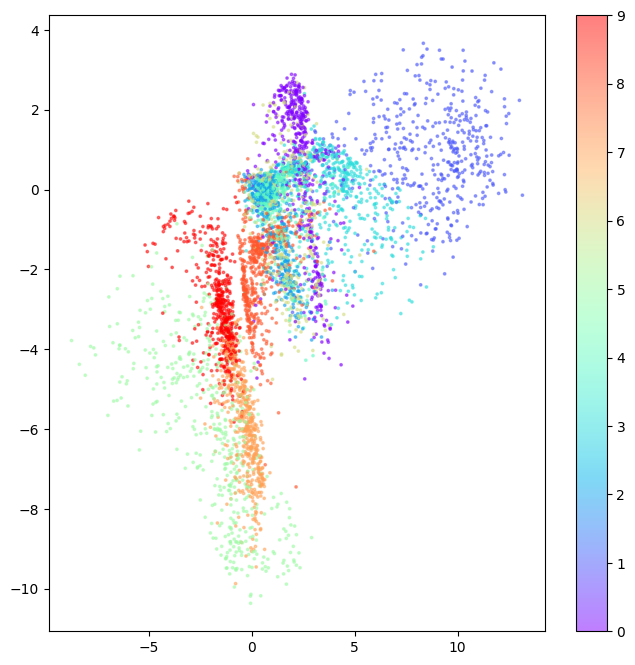

In [ ]:
#color the embeddings as per label ids

example_labels = y_test[:number_images]

plt.figure(figsize=(fig_size,fig_size))
plt.scatter(
    embeddings[:,0], embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.5,
    s=3
)
plt.colorbar()
plt.show()

# Lets try to generate NEW IMAGES

In [ ]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6,3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width*grid_height, EMBEDDING_DIM)
)

In [ ]:
#Decode the sample points

In [ ]:
sample

array([[  9.8941798 ,  -3.44037354],
       [ -6.39595848,  -8.50707233],
       [ -4.28497972,  -5.82472705],
       [ 11.00157554,  -1.76595616],
       [  3.41488786,  -0.32389343],
       [ -2.27887911, -10.10232177],
       [ -1.41724757,  -7.8723831 ],
       [ -5.4618552 ,  -7.4886958 ],
       [  4.33331833,   0.72200478],
       [  2.77581414,  -9.76137938],
       [  2.11535066,   3.10887029],
       [  6.86974764,  -6.86968499],
       [  3.62110873,  -1.03073902],
       [  6.28255879,   3.51633985],
       [  9.99858959,   3.02333949],
       [  5.03525185,  -8.86975285],
       [  5.62232299,  -2.06917822],
       [ -1.97845733,   2.27755045]])

In [ ]:
reconstrcted_images = decoder.predict(sample)

1/1 [==============================] - 0s 197ms/step


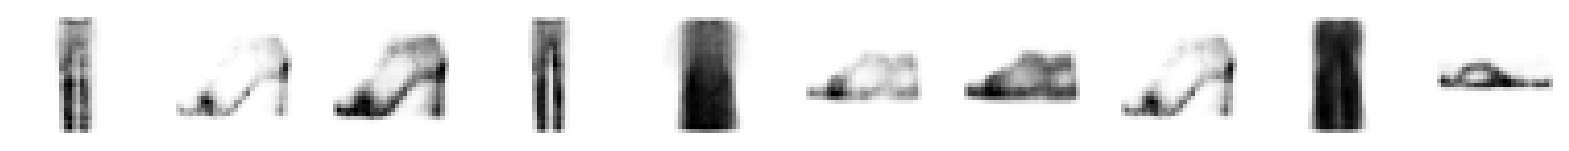

In [ ]:
display_images(reconstrcted_images)

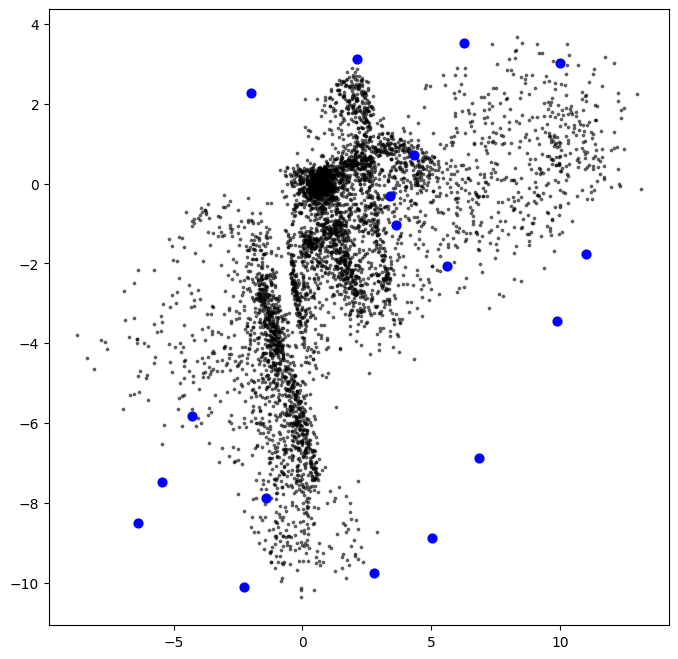

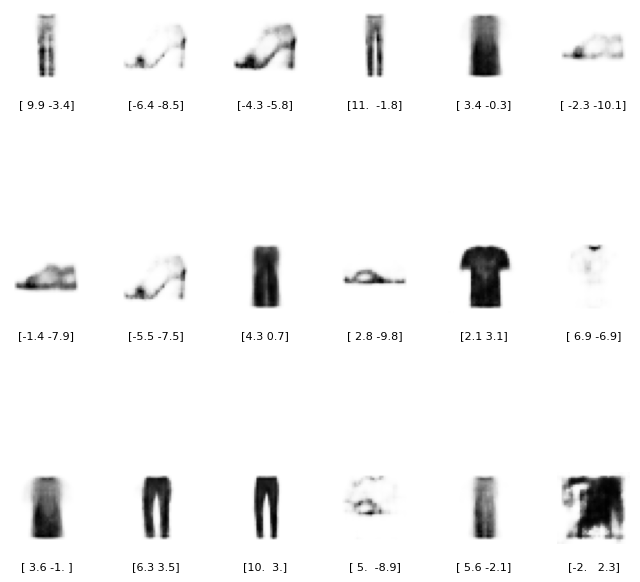

In [ ]:
plt.figure(figsize=(fig_size, fig_size))
plt.scatter(embeddings[:,0], embeddings[:, 1], c="black", alpha=0.5, s=3)

#newly generated points plotting
plt.scatter(sample[:,0], sample[:,1], c="#0000FF", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(fig_size, fig_size))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(grid_width*grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis("off")
  ax.text(
      0.5,
      -0.35,
      str(np.round(sample[i,:], 1)),
      fontsize=8,
      ha="center",
      transform=ax.transAxes
  )
  ax.imshow(reconstrcted_images[i, :, :], cmap="Greys")